In [1]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import plotly.graph_objs as go
import plotly.io as pio
from mlxtend.plotting import plot_decision_regions

f = '/Users/shenchingfeng/Documents/1112/機器學習/Homework 2/all.csv'

df = pd.read_csv(f)
df.drop(['Unnamed: 0'], axis = 1, inplace = True) ## Red wine == 1 ; White wine == 0

result = pd.DataFrame(columns = ["model", "accuracy"])

select_col = df.drop('wine', axis = 1).columns
for i in select_col:
    df[i], lambda_value = stats.yeojohnson(df[i])

# Cross Validation

### 10-Fold CV

In [2]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

### Grid Search CV

In [3]:
model = LogisticRegression(max_iter = int(1e6))
X = df.drop('wine', axis = 1)
y = df.wine

params = {
    'C': [10**i for i in range(-4, 5)],
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'solver': ['lbfgs', 'liblinear', 'saga']   
}

grid_search = GridSearchCV(model, param_grid = params, cv = kf)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

result = result.append({'model': 'Logistic Regression', 'accuracy': round(grid_search.best_score_, 4)}, ignore_index = True)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
630 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
Va

Best parameters: {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.9904582197463553


/var/folders/56/1hl93h654354jd5vh2zjmd640000gn/T/ipykernel_26779/3536800315.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'model': 'Logistic Regression', 'accuracy': round(grid_search.best_score_, 4)}, ignore_index = True)


# Feature Selection

## Stepwise Selection

In [4]:
X = df.drop(['wine'], axis = 1)
y = df.wine

sfs = SFS(
    cv = kf, 
    estimator = LogisticRegression(max_iter = int(1e7), C = 10000, penalty = 'l2', solver = 'lbfgs'),
    forward = True,
    floating = True,
    k_features = X.shape[1], 
    scoring='f1'
)

sfs.fit(X, y)

print(sfs.feature_names)
print(sfs.feature_names_to_idx_mapper)
print(sfs.k_score_)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
{'fixed acidity': 0, 'volatile acidity': 1, 'citric acid': 2, 'residual sugar': 3, 'chlorides': 4, 'free sulfur dioxide': 5, 'total sulfur dioxide': 6, 'density': 7, 'pH': 8, 'sulphates': 9, 'alcohol': 10, 'quality': 11}
0.9805748830525051


In [5]:
import plotly.graph_objects as go

metric_dict = sfs.get_metric_dict()
k_features = list(metric_dict.keys())
avg_scores = np.array([metric_dict[k]['avg_score'] for k in k_features])
std_devs = np.array([metric_dict[k]['std_dev'] for k in k_features])

fig = go.Figure()
fig.add_trace(
    go.Scatter(
    x = k_features, y = avg_scores, 
    mode = 'lines+markers', name = 'Average Score'
    )
)

fig.update_layout(
    title = {
        'text': 'Stepwise Selection',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    }, 
    xaxis_title = {
        'text': 'Number of Features',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Performence (F1)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    width = 1200, height = 800
)

fig.show()

## Lasso

In [6]:
X = df.drop(['wine'], axis = 1)
y = df.wine

lasso = Lasso()
params = {
    'alpha': [10**i for i in range(-3, 4)],
    'selection': ['cyclic', 'random']
}
gridlasso = GridSearchCV(lasso, param_grid = params, cv = kf)
gridlasso.fit(X, y)

print("Best alpha:", gridlasso.best_params_)
print("Best scores:", gridlasso.best_score_)

coefficients = gridlasso.best_estimator_.coef_
importance = np.abs(coefficients)
print(np.array(X.columns)[importance > 0.01])

Best alpha: {'alpha': 0.001, 'selection': 'random'}
Best scores: 0.7107288238394426
['volatile acidity' 'free sulfur dioxide' 'sulphates' 'quality']


In [7]:
best_lasso = gridlasso.best_estimator_

alphas = np.array(gridlasso.cv_results_['param_alpha'].data, dtype = 'float')
coefs = gridlasso.cv_results_['mean_test_score']

fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = np.log10(alphas), y = coefs, 
    mode = 'lines+markers'
    )
)

fig.update_layout(
    title = {
        'text': 'Lasso coefficients as a function of Log alpha',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 
        'x': 0.5
    }, 
    width = 1200, height = 800,
    xaxis_title = {
        'text': 'Log(alpha)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Coefficient',
        'font': {'size': 24, 'family': 'Gulliver'}
    }, 
)

fig.show()

## Feature Group

In [17]:
Stepwise = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide']
Lasso =  ['fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol']

feature = []

for i in df.drop('wine', axis = 1).columns:
    for i in Stepwise:
        if i not in feature:
            feature.append(i)
        else:
            continue
    for i in Lasso:
        if i not in feature:
            feature.append(i)
        else:
            continue
print(feature)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']


# Model

In [18]:
X = df[feature]
y = df.wine

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

lr = LogisticRegression(C = 10000, penalty = 'l2', solver = 'lbfgs')
model = lr.fit(x_train, y_train)
y_pred = model.predict(x_test)

## Model Performance

[10/10] features ████████████████████ Time elapsed: 0 seconds

Text(0.5, 1.0, 'Feature Importance of Logistic Regression')

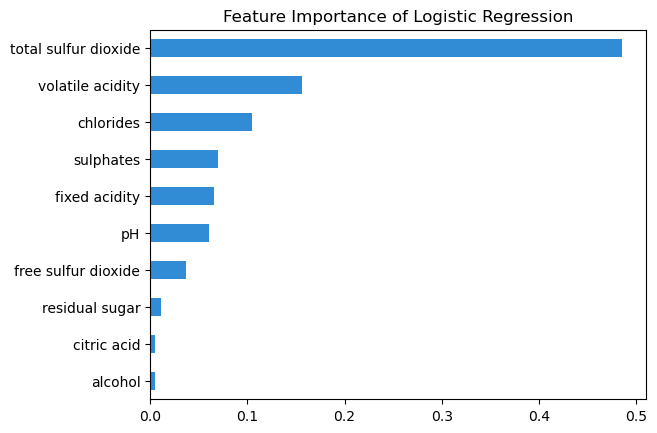

In [19]:
interpreter = Interpretation(
    x_test, feature_names = X.columns
)

pyint_model = InMemoryModel(
    lr.predict_proba,
    examples = x_train
)

plots= interpreter.feature_importance.plot_feature_importance(pyint_model, ascending = False, progressbar = True)
plt.title('Feature Importance of Logistic Regression')

## Decision Region

In [21]:
feature_name = 'volatile acidity'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)

1


### With mlxtend.plotting plot_decision_regions()

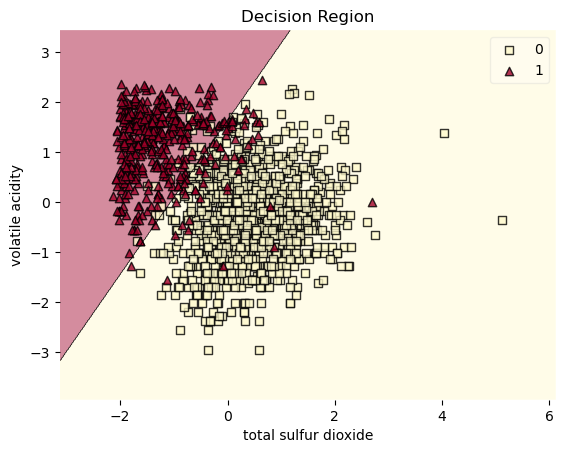

In [24]:
plot_decision_regions(
    x_test[:, [6, 1]], 
    y_test.values, 
    clf = LogisticRegression(C = 10000, penalty = 'l2', solver = 'lbfgs').fit(x_train[:, [6, 1]], y_train.values),
    colors='#fffacd,#a00028'
)

plt.title('Decision Region')
plt.xlabel('total sulfur dioxide')
plt.ylabel('volatile acidity')
plt.show()

### With Scatter plot of Plotly

In [11]:
trace = go.Scatter(
    x = x_test[:, 1],
    y = x_test[:, 6],
    mode = 'markers',
    marker = dict(
        color = y_pred,
        symbol = y_pred,
        size = 8,
        opacity = 0.9,
        colorscale = [[0, '#fffacd'], [1, '#a00028']],
        line = dict(color = '#444444', width = 0.5)
    )
)

layout = go.Layout(
    title = {
        'text': 'Decision Region',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    },
    xaxis = dict(
        title = {
            'text': 'volatile acidity', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    yaxis = dict(
        title = {
            'text': 'total sulfur dioxide', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    margin = dict(l = 50, r = 50, t = 80, b = 50),
    hovermode = 'closest', 
    width = 800, height = 800,
    showlegend = False,
    template = 'ggplot2'
)

fig = go.Figure(
    data = [trace], 
    layout = layout
)

pio.show(fig)

## Confusion Matrix

In [20]:
acu = metrics.accuracy_score(y_test, y_pred)
pre_class, r_class, f_class, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average = 'weighted')

print("Acurracy: ", round(acu * 100, 4), '%')
print('Precision:', round(pre_class * 100, 4), '%')
print('Recall:', round(r_class * 100, 4), '%')
print('f1:', round(f_class * 100, 4), '%')

cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_norm = pd.DataFrame(cm_norm)
cm_norm

Acurracy:  99.2 %
Precision: 99.1995 %
Recall: 99.2 %
f1: 99.1997 %


,0,1
0,0.994962,0.005038
1,0.016129,0.983871


## Receiver Operating Characteristic Curve

In [16]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
    y_test, 
    model.predict_proba(x_test)[:, 1]
)

roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(
    x = fpr, y = tpr, 
    mode = 'lines', 
    line = dict(width = 2),
    # name = 'Logistic Regression (AUC = {:0.2f})'.format(roc_auc)
)

trace2 = go.Scatter(
        x = [0, 1], y = [0, 1],
        mode = 'lines',
        line = dict(color = 'navy', width = 2, dash = 'dash'),
        showlegend = False
)

layout = go.Layout(
        title = {
            'text': 'ROC Curves (AUC = {:0.2f})'.format(roc_auc),
            'font': {
                'size': 40, 'family': 'Gulliver'
            }, 
            'x': 0.5, 'y': 0.95
        },
        xaxis = dict(
            title = {
                'text': 'False Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        yaxis = dict(
            title = {
                'text': 'True Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        width = 1200, height = 800,
        showlegend = False
)

fig = go.Figure(
    data = [trace1, trace2], 
    layout = layout
)

fig.show()

# Model Compexity

In [14]:
C_range = [ 10**i for i in range(-4, 5) ]

train_errors = []
test_errors = []

for C in C_range:
    clf = LogisticRegression(
        C = C, random_state = 42, penalty = 'l2', solver = 'lbfgs'
    )
    clf.fit(x_train, y_train)
    train_errors.append(1 - clf.score(x_train, y_train))
    test_errors.append(1 - clf.score(x_test, y_test))

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = [ np.log10(1/C) for C in C_range ], y = train_errors,
        mode = 'lines+markers',
        name = 'Train Error'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ np.log10(1/C) for C in C_range ], y = test_errors,
        mode = 'lines+markers',
        name = 'Test Error'
    )
)
fig.update_layout(
    title = {
        'text': 'Model Complexity for Logistic Regression',
        'font': {
            'size': 40, 'family': 'Gulliver'
        },
        'x': 0.5
    },
    width = 800, height = 600,
    xaxis_title = {
        'text': 'Regularization Parameters Log(1/C)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    },
    yaxis_title = {
        'text': 'Classification Error',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }
)


fig.show()